In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_dataset = "/content/drive/MyDrive/Class/nam-4/ky-1/ML/TH2/Dataset/LSTM"

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
# Instead of importing from keras.layers.core, import directly from keras.layers
from keras.layers import Dense, Dropout, Activation, LSTM
#from keras.layers.core import Dense, Dropout, Activation # This line is replaced
#from keras.layers.recurrent import LSTM # This line is replaced
from keras.models import load_model
import keras
import h5py
import requests
import os

In [ ]:
data_df = pd.read_csv(path_dataset + "/prices-split-adjusted.csv", index_col = 0)
data_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
df2 = pd.read_csv(path_dataset + "/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [ ]:
data_df = data_df[data_df.symbol == 'AAPL']
data_df.drop(columns=['symbol'],inplace=True)
data_df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0


In [ ]:
data_df.shape

(1762, 5)

In [ ]:
data_df.tail()

,open,close,low,high,volume
date,,,,,
2016-12-23,115.589996,116.519997,115.589996,116.519997,14249500.0
2016-12-27,116.519997,117.260002,116.489998,117.800003,18296900.0
2016-12-28,117.519997,116.760002,116.199997,118.019997,20905900.0
2016-12-29,116.449997,116.730003,116.400002,117.110001,15039500.0
2016-12-30,116.650002,115.820000,115.430000,117.199997,30586300.0


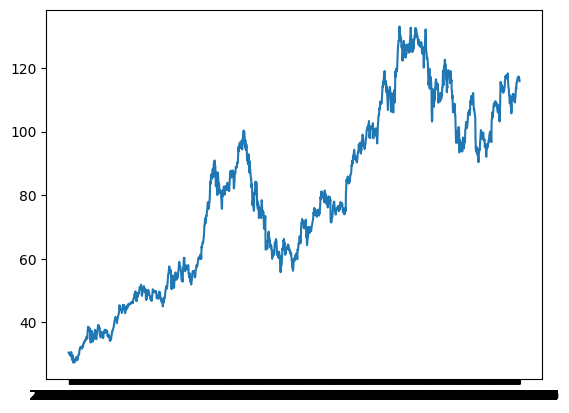

In [ ]:
plt.plot(data_df['close'])
plt.show()

In [ ]:
data_df['date'] = data_df.index
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


In [ ]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [ ]:
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['close'].values.reshape(-1, 1))

In [ ]:
dataset[0:10]

array([[0.02971784],
       [0.03021854],
       [0.02560389],
       [0.02507612],
       [0.0269707 ],
       [0.02444008],
       [0.02120576],
       [0.02517085],
       [0.02351986],
       [0.0187834 ]])

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1233 529


In [ ]:
print(len(data_df))
print(1233 + 529)

1762
1762


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15)
(1217,)
(513, 15)
(513,)


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 1, 15)
(1217,)
(513, 1, 15)
(513,)


In [ ]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1217/1217 - 4s - 4ms/step - loss: 0.0049
Epoch 2/20
1217/1217 - 2s - 1ms/step - loss: 4.3291e-04
Epoch 3/20
1217/1217 - 2s - 2ms/step - loss: 4.0032e-04
Epoch 4/20
1217/1217 - 4s - 3ms/step - loss: 3.5531e-04
Epoch 5/20
1217/1217 - 7s - 5ms/step - loss: 3.4323e-04
Epoch 6/20
1217/1217 - 2s - 2ms/step - loss: 2.9894e-04
Epoch 7/20
1217/1217 - 3s - 2ms/step - loss: 3.1183e-04
Epoch 8/20
1217/1217 - 2s - 1ms/step - loss: 2.7843e-04
Epoch 9/20
1217/1217 - 3s - 2ms/step - loss: 2.4762e-04
Epoch 10/20
1217/1217 - 3s - 3ms/step - loss: 2.7494e-04
Epoch 11/20
1217/1217 - 3s - 2ms/step - loss: 2.6762e-04
Epoch 12/20
1217/1217 - 4s - 3ms/step - loss: 2.3948e-04
Epoch 13/20
1217/1217 - 2s - 1ms/step - loss: 2.5621e-04
Epoch 14/20
1217/1217 - 3s - 2ms/step - loss: 2.3932e-04
Epoch 15/20
1217/1217 - 3s - 2ms/step - loss: 2.4847e-04
Epoch 16/20
1217/1217 - 3s - 3ms/step - loss: 2.1868e-04
Epoch 17/20
1217/1217 - 4s - 3ms/step - loss: 2.3257e-04
Epoch 18/20
1217/1217 - 2s - 1ms/step - loss: 2.4460e-0

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 2.12 RMSE
Test Score: 4.17 RMSE


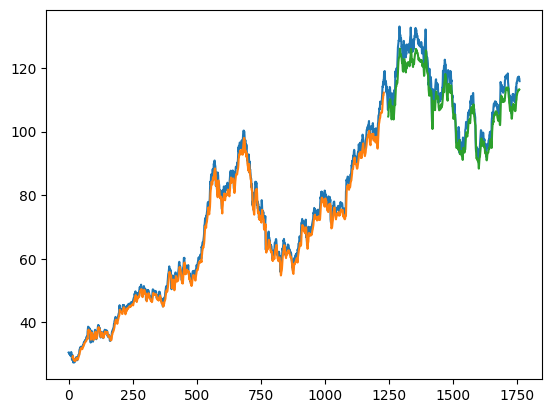

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()